In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from joblib import Parallel, delayed
import math
from statsmodels.tsa.stattools import acf
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error,
    median_absolute_error
)
import os
from tqdm import tqdm
import warnings
from scipy.stats import linregress

In [10]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features while maintaining existing structure"""
    # Adjust k_neighbors if the dataset is small
    actual_k = min(k_neighbors, len(df) - 1)  # Make sure k is at most n-1
    if actual_k < k_neighbors:
        print(f"Reducing k_neighbors from {k_neighbors} to {actual_k} due to small sample size")
    
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        # Use adaptive k value
        k_query = min(k_neighbors + 1, len(all_coords))
        distances, indices = tree.query(coords, k=k_query)
        
        # If k_query is 1, we need special handling
        if k_query == 1:
            # Just return zeros or appropriate values for a single point
            n_samples = len(chunk_data)
            return {
                'knn_price_mean': np.zeros(n_samples),
                'knn_price_std': np.zeros(n_samples),
                'knn_price_median': np.zeros(n_samples),
                'knn_price_range': np.zeros(n_samples),
                'price_diff_from_neighbors': np.zeros(n_samples),
                'distance_weighted_price': np.zeros(n_samples)
            }
        
        # Process neighbor data if we have multiple points
        # Handle the case where k_query is 2 (self + 1 neighbor)
        if k_query == 2:
            neighbor_prices = np.take(all_prices, indices[:, 1:]).reshape(-1, 1)
            weights = np.ones((len(distances), 1))  # Only one neighbor, so weight is 1
        else:
            # Convert distances to weights (inverse distance weighting)
            weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
            weights = weights / weights.sum(axis=1, keepdims=True)
            neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        # Calculate neighbor statistics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)  # Ignore NaN warnings
            mean_prices = np.nanmean(neighbor_prices, axis=1)
            std_prices = np.nanstd(neighbor_prices, axis=1)
            
            # Handle single-neighbor case for median and range
            if neighbor_prices.shape[1] == 1:
                median_prices = neighbor_prices.flatten()
                range_prices = np.zeros(len(neighbor_prices))
            else:
                median_prices = np.nanmedian(neighbor_prices, axis=1)
                range_prices = np.ptp(neighbor_prices, axis=1)
            
            # Weighted prices
            if neighbor_prices.shape[1] == 1:
                weighted_prices = neighbor_prices.flatten()
            else:
                weighted_prices = np.sum(weights * neighbor_prices, axis=1)
        
        return {
            'knn_price_mean': mean_prices,
            'knn_price_std': std_prices,
            'knn_price_median': median_prices,
            'knn_price_range': range_prices,
            'price_diff_from_neighbors': chunk_data['price'].values - mean_prices,
            'distance_weighted_price': weighted_prices
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            actual_k,  # Use adjusted k value
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        # Avoid division by zero
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
        else:
            spatial_features[col] = 0  # Set to zero if std is zero
    
    return spatial_features

def print_day_by_day_summary(evaluation_results):
    """Print a summary of day-by-day performance with stability metrics"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    error_stability = evaluation_results.get('error_stability', {})
    error_stability_alt = evaluation_results.get('error_stability_alt', {})
    
    print("\n===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability (Method 1 - Time Series Analysis) ===")
    if 'mae_stability_coefficient' in error_stability:
        print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
        print(f"  MAE Trend Slope: {error_stability.get('mae_trend_slope', 0):.6f}")
        print(f"  MAE Trend R²: {error_stability.get('mae_trend_r2', 0):.4f}")
    else:
        print("  Error stability metrics not available.")
    
    print("\n=== Error Stability (Method 2 - Direct Calculation) ===")
    if 'mae_stability_coefficient' in error_stability_alt:
        print(f"  MAE Stability Coefficient: {error_stability_alt['mae_stability_coefficient']:.4f}")
    else:
        print("  Alternative error stability metrics not available.")
    
    print("\n  (Lower stability coefficient indicates more consistent predictions across days)")
    
    # Calculate overall feature importance by averaging across days
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def evaluate_day_by_day_performance(daily_results):
    """Evaluate performance metrics for daily predictions with stability analysis"""
    # Combine all daily predictions into a single dataframe
    all_results = pd.concat(daily_results)
    
    # Calculate overall metrics
    y_true = all_results['price']
    y_pred = all_results['predicted']
    errors = y_true - y_pred
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0].strftime('%Y-%m-%d')
        y_true_day = day_df['price']
        y_pred_day = day_df['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Calculate error autocorrelation
    error_autocorr = calculate_error_autocorrelation(errors, max_lag=7)
    
    # Calculate error stability metrics (Method 1 - using daily metrics)
    error_stability = calculate_error_stability(daily_metrics_df)
    
    # Make sure date_str column exists for the alternative method
    if 'date_str' not in all_results.columns:
        all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    
    # Calculate error stability metrics (Method 2 - using grouped results)
    error_stability_alt = calculate_error_stability_alternative(all_results)
    
    return {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorr,
        'error_stability': error_stability,
        'error_stability_alt': error_stability_alt
    }

def calculate_error_stability(daily_metrics):
    """Calculate error stability metrics from daily performance data"""
    # Calculate coefficient of variation for MAE (lower = more stable)
    mae_values = daily_metrics['mae'].values
    
    # Prevent division by zero
    if np.mean(mae_values) == 0:
        mae_stability_coefficient = float('inf')
    else:
        mae_stability_coefficient = np.std(mae_values) / np.mean(mae_values)
    
    # Calculate trend in errors using linear regression
    x = np.arange(len(mae_values))
    
    # Handle case with too few points for regression
    if len(x) < 2:
        slope, r_value = 0, 0
    else:
        slope, _, r_value, _, _ = linregress(x, mae_values)
    
    return {
        'mae_stability_coefficient': mae_stability_coefficient,
        'mae_trend_slope': slope,
        'mae_trend_r2': r_value**2
    }

def calculate_error_stability_alternative(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
   
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
   
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
   
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
   
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def plot_day_by_day_results(evaluation_results):
    """Plot the results from day-by-day predictions"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted by Day
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],  # Changed from 'actual' to 'price'
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())  # Changed
    max_val = max(all_results['price'].max(), all_results['predicted'].max())  # Changed
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['price'] - all_results['predicted']  # Changed
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title('Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def run_day_by_day_xgboost_ablation(train_path, test_path, features_to_drop=None, output_dir=None, sample_size=5000000):
    """Run XGBoost with day-by-day retraining, with optional feature ablation"""
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Default features to drop if none specified
    if features_to_drop is None:
        features_to_drop = []
    
    # Standard columns to always drop
    all_features_to_drop = features_to_drop
    
    print(f"Features being dropped: {all_features_to_drop}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # For testing - take only a small sample of listings
    unique_listings = test_data['listing_id'].unique()
    if len(unique_listings) > sample_size:
        print(f"Limiting to {sample_size} random listings for testing")
        selected_listings = np.random.choice(unique_listings, sample_size, replace=False)
        train_data = train_data[train_data['listing_id'].isin(selected_listings)]
        test_data = test_data[test_data['listing_id'].isin(selected_listings)]

    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Drop specified columns if they exist
    for col in all_features_to_drop:
        if col in train_data.columns:
            print(f"Dropping column: {col}")
            train_data = train_data.drop(col, axis=1)
        if col in test_data.columns:
            test_data = test_data.drop(col, axis=1)
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Initialize XGBoost model with fewer estimators for faster testing
    xgb_model = XGBRegressor(
        n_estimators=200,  # Reduced from 300
        learning_rate=0.01,  # Increased from 0.01 for faster convergence
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,  # Reduced from 20
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method='hist',
        grow_policy='lossguide'
    )
    
    # Initialize results storage
    daily_results = []
    feature_importance_over_time = []
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        # Create spatial features for training data
        train_spatial = create_spatial_features(train_data)
        
        # Create spatial features for test data (only current day)
        day_test_spatial = create_spatial_features(day_test)
        
        # Prepare feature matrices
        X_train = pd.concat([train_data.drop(['listing_id', 'date', 'price'], axis=1), train_spatial], axis=1)
        X_test_day = pd.concat([day_test.drop(['listing_id', 'date', 'price'], axis=1), day_test_spatial], axis=1)
        
        y_train = train_data['price']
        y_test_day = day_test['price']
        
        # Train model on all training data
        xgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test_day, y_test_day)],
            verbose=False
        )
        
        # Make predictions for current day
        y_pred_day = xgb_model.predict(X_test_day)
        
        # Store feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_model.feature_importances_,
            'date': day
        })
        feature_importance_over_time.append(feature_importance)
        
        # Store results for the day - USING PRICE INSTEAD OF ACTUAL
        day_results_df = pd.DataFrame({
            'date': day_test['date'],
            'listing_id': day_test['listing_id'],
            'price': y_test_day,  # Using 'price' not 'actual'
            'predicted': y_pred_day,
            'error': y_test_day - y_pred_day,
            'abs_error': np.abs(y_test_day - y_pred_day),
            'pct_error': np.abs((y_test_day - y_pred_day) / y_test_day) * 100
        })
        daily_results.append(day_results_df)
        
        # Update training data with the current day's actual values
        train_data = pd.concat([train_data, day_test], ignore_index=True)
    
    # Evaluate performance across all days
    evaluation_results = evaluate_day_by_day_performance(daily_results)
    
    # Combine feature importance data
    all_feature_importance = pd.concat(feature_importance_over_time)
    
    # Add to evaluation results
    evaluation_results['feature_importance'] = all_feature_importance
    evaluation_results['dropped_features'] = features_to_drop
    
    # Calculate error stability metrics for the plot_error_analysis function
    all_results = evaluation_results['all_results']
    
    # Group errors by date to calculate daily error metrics
    all_results['date_obj'] = pd.to_datetime(all_results['date']).dt.date
    grouped_errors = all_results.groupby('date_obj')
    
    # Calculate daily MAE and error standard deviation
    daily_mae = grouped_errors['abs_error'].mean()
    daily_error_std = grouped_errors['error'].std()
    
    # Add error stability metrics to evaluation results
    mae_values = daily_mae.values
    evaluation_results['error_stability'] = {
    'daily_mae': daily_mae,
    'daily_error_std': daily_error_std,
    'mae_stability_coefficient': np.std(mae_values) / np.mean(mae_values) if np.mean(mae_values) > 0 else float('inf'),
    'mae_trend_slope': linregress(range(len(mae_values)), mae_values)[0] if len(mae_values) > 1 else 0,
    'mae_trend_r2': linregress(range(len(mae_values)), mae_values)[2]**2 if len(mae_values) > 1 else 0
        }
    
    # Store the output directory in evaluation results
    if output_dir:
        evaluation_results['output_dir'] = output_dir
    
    # Create suffix for output directory based on dropped features
    if output_dir and features_to_drop:
        feature_suffix = '_without_' + '_'.join([f.replace('_', '') for f in features_to_drop[:2]])
        if len(features_to_drop) > 2:
            feature_suffix += f'_and_{len(features_to_drop)-2}_more'
        output_dir = output_dir + feature_suffix
    
    # Save results if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Combine all daily results into a single DataFrame
        all_results_df = pd.concat(daily_results, ignore_index=True)
        
        # Add date_str column for grouping like in naive baseline
        all_results_df['date_str'] = pd.to_datetime(all_results_df['date']).dt.strftime('%Y-%m-%d')
        
        # Create output file path to match naive baseline structure
        output_file = os.path.join(output_dir, 'xgboost_results.csv')
        
        # Include location data if available, matching naive baseline
        if 'longitude' in test_data.columns and 'latitude' in test_data.columns:
            location_data = test_data[['listing_id', 'longitude', 'latitude']].drop_duplicates()
            results_with_location = all_results_df.merge(location_data, on='listing_id', how='left')
            results_with_location.to_csv(output_file, index=False)
            print(f"Results saved to {output_file} with location data")
        else:
            all_results_df.to_csv(output_file, index=False)
            print(f"Results saved to {output_file}")
        
        # Save daily metrics matching the naive baseline format
        metrics_path = output_file.replace('.csv', '_daily_metrics.csv')
        evaluation_results['daily_metrics'].to_csv(metrics_path, index=False)
        print(f"Daily metrics saved to {metrics_path}")
        
        # Save feature importance
        importance_path = output_file.replace('.csv', '_feature_importance.csv')
        all_feature_importance.to_csv(importance_path, index=False)
        print(f"Feature importance saved to {importance_path}")
        
        # Save a summary file with key metrics
        with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
            f.write(f"XGBoost Model Summary\n")
            f.write(f"====================\n\n")
            f.write(f"Features dropped: {features_to_drop}\n\n")
            f.write(f"Overall Metrics:\n")
            for k, v in evaluation_results['overall_metrics'].items():
                f.write(f"  {k}: {v:.6f}\n")
    
    # Print summary
    print_day_by_day_summary(evaluation_results)
    
    # Create plots
    plot_day_by_day_results(evaluation_results)
    
    # Create error analysis plot
    plot_error_analysis(evaluation_results)
    
    return evaluation_results

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results.get('error_stability_alt', evaluation_results.get('error_stability', {}))
   
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
   
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
   
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
   
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
   
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
   
    # Plot error stability (daily MAE and error std dev)
    if 'daily_mae' in error_stability and 'daily_error_std' in error_stability:
        daily_mae = error_stability['daily_mae']
        daily_error_std = error_stability['daily_error_std']
       
        ax1 = axes[1]
        ax2 = ax1.twinx()
       
        # Plot MAE
        ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Mean Absolute Error', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
       
        # Plot error std dev
        ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
        ax2.set_ylabel('Error Standard Deviation', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
       
        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
       
        axes[1].set_title('Error Stability Over Time')
    else:
        axes[1].text(0.5, 0.5, 'Error stability data not available', 
                    horizontalalignment='center', verticalalignment='center')
   
    plt.tight_layout()
    plt.show()
    
    # Create additional plot to compare stability coefficients if both methods are available
    if 'error_stability' in evaluation_results and 'error_stability_alt' in evaluation_results:
        stability1 = evaluation_results['error_stability'].get('mae_stability_coefficient')
        stability2 = evaluation_results['error_stability_alt'].get('mae_stability_coefficient')
        
        if stability1 is not None and stability2 is not None:
            plt.figure(figsize=(8, 5))
            methods = ['Method 1\n(Time Series)', 'Method 2\n(Direct)']
            values = [stability1, stability2]
            
            plt.bar(methods, values, color=['blue', 'green'])
            plt.ylabel('MAE Stability Coefficient\n(lower is better)')
            plt.title('Comparison of Stability Coefficients')
            
            # Add values on top of bars
            for i, v in enumerate(values):
                plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
                
            plt.tight_layout()
            plt.show()

def run_ablation_experiment(subset_name, test_period, features_to_drop=None, base_dir=None, sample_size=50000000):
    """Run ablation experiments for a specified subset and test period."""
    """
    Run ablation experiments for a specified subset and test period.
    
    Parameters:
    -----------
    subset_name : str
        Name of the subset folder (e.g., "poorest_neighborhoods_subset")
    test_period : str
        Testing period (e.g., "test_feb", "test_april", "test_june")
    features_to_drop : list, optional
        List of features to drop for ablation testing. If None, runs both baseline and ablation.
    base_dir : str, optional
        Base directory containing subsets. If None, uses default directory.
    sample_size : int, optional
        Number of listings to use for testing
        
    Returns:
    --------
    dict
        Dictionary containing baseline and ablation results
    """
    # Set default values
    if base_dir is None:
        base_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset"
    if features_to_drop is None:
        # Use just a few features for quick testing
        features_to_drop = ['price_lag_1d', 'price_lag_7d', 'price_lag_30d', 'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d']
    
    # Create paths
    subset_dir = os.path.join(base_dir, subset_name)
    train_path = os.path.join(subset_dir, "train.csv")
    test_path = os.path.join(subset_dir, f"{test_period}.csv")
    base_output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Model"
    
    # Run baseline model (with all features)
    print(f"\n=== RUNNING BASELINE MODEL FOR {subset_name}, {test_period} ===")
    baseline_results = run_day_by_day_xgboost_ablation(
        train_path,
        test_path,
        features_to_drop=[],
        output_dir=base_output_dir + "_baseline",
        sample_size=sample_size
    )
    
    # Run model with specified features dropped
    print(f"\n=== RUNNING MODEL WITHOUT {len(features_to_drop)} FEATURES ===")
    ablation_results = run_day_by_day_xgboost_ablation(
        train_path,
        test_path,
        features_to_drop=features_to_drop,
        output_dir=base_output_dir,
        sample_size=sample_size
    )
    
    # Compare results
    print("\n=== PERFORMANCE COMPARISON ===")
    compare_results(baseline_results, ablation_results, features_to_drop)
    
    return {
        "baseline": baseline_results,
        "ablation": ablation_results
    }

def compare_results(baseline_results, ablation_results, features_dropped):
    """
    Compare and print the baseline and ablation results.
    
    Parameters:
    -----------
    baseline_results : dict
        Results from the baseline model
    ablation_results : dict
        Results from the ablation model
    features_dropped : list
        List of features that were dropped in the ablation test
    """
    baseline_metrics = baseline_results['overall_metrics']
    ablation_metrics = ablation_results['overall_metrics']
    
    metrics_to_compare = ['rmse', 'mae', 'r2', 'mape']
    
    print(f"Features dropped: {', '.join(features_dropped)}")
    print(f"{'Metric':<20} {'Baseline':<15} {'Ablation':<15} {'Difference':<15} {'% Change':<15}")
    print("="*80)
    
    for metric in metrics_to_compare:
        baseline_val = baseline_metrics[metric]
        ablation_val = ablation_metrics[metric]
        diff = ablation_val - baseline_val
        pct_change = (diff / baseline_val) * 100
        
        # For R², higher is better, so we reverse the sign of the difference
        if metric == 'r2':
            diff = -diff
            pct_change = -pct_change
        
        print(f"{metric:<20} {baseline_val:<15.6f} {ablation_val:<15.6f} {diff:<15.6f} {pct_change:<15.2f}%")



========= TESTING top_price_changers_subset - test_feb =========

=== RUNNING BASELINE MODEL FOR top_price_changers_subset, test_feb ===
Processing dataset: train.csv
Features being dropped: []
Loading data...
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:53<05:21, 53.60s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 

Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Model_baseline\xgboost_results.csv with location data
Daily metrics saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Model_baseline\xgboost_results_daily_metrics.csv
Feature importance saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Model_baseline\xgboost_results_feature_importance.csv

===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.1319
MAE: 0.0846
R²: 0.9790
MAPE: 25.4125%
Explained Variance: 0.9791
Median Abs Error: 0.0704

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.139756 0.087208 35.365054       7864
2024-02-10 0.136820 0.083706 17.450102       7864
2024-02-11 0.137334 0.088642 26.720318       7864
2024-02-12 0.129750 0.082407 18.580356       7864
2024-02-13 0.127236 0.081676 19.250068       7864
2024-02-14 0.129328 0.085760 24.336531       7864
2024-02-15 0.122520 0.082937 36.184829       7864


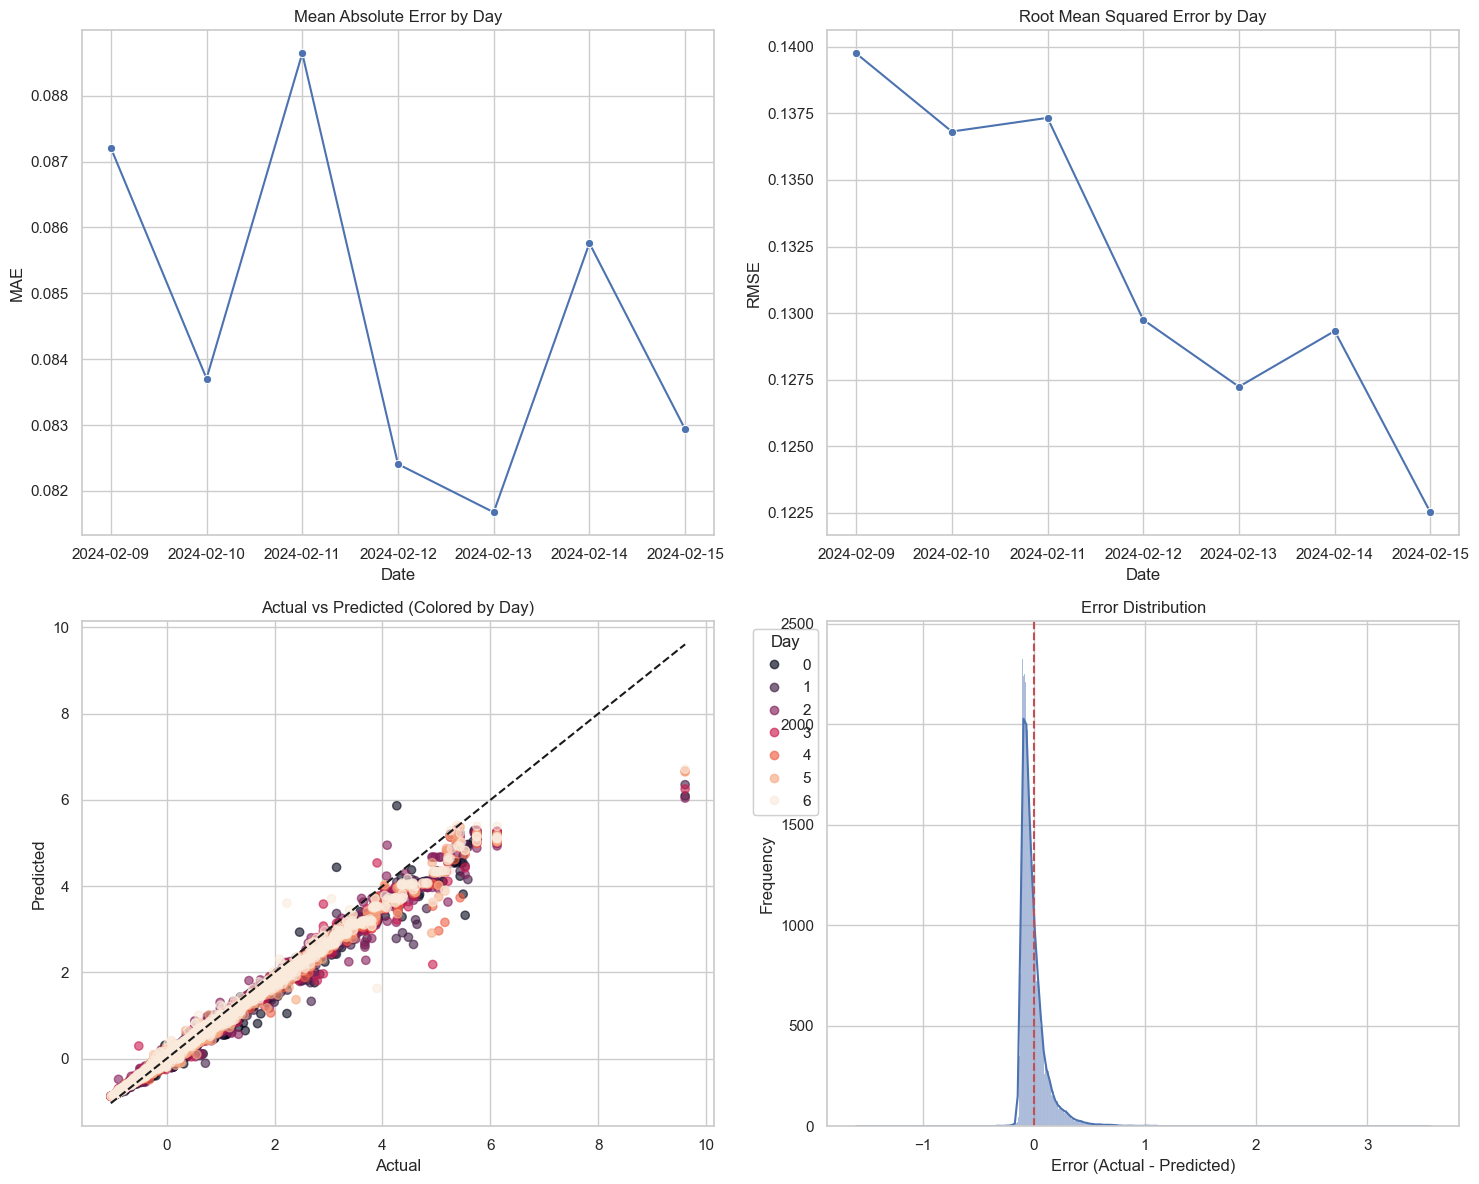

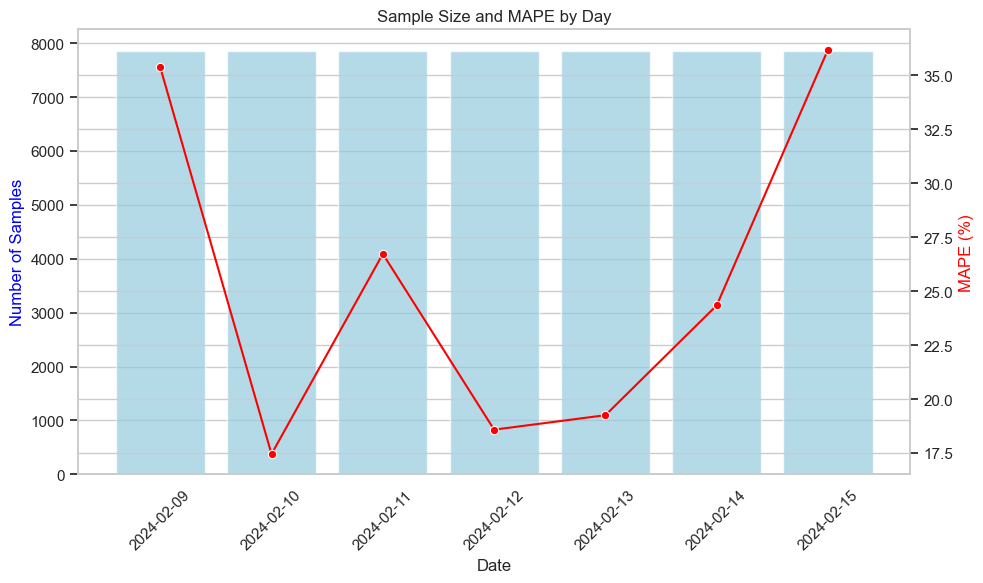

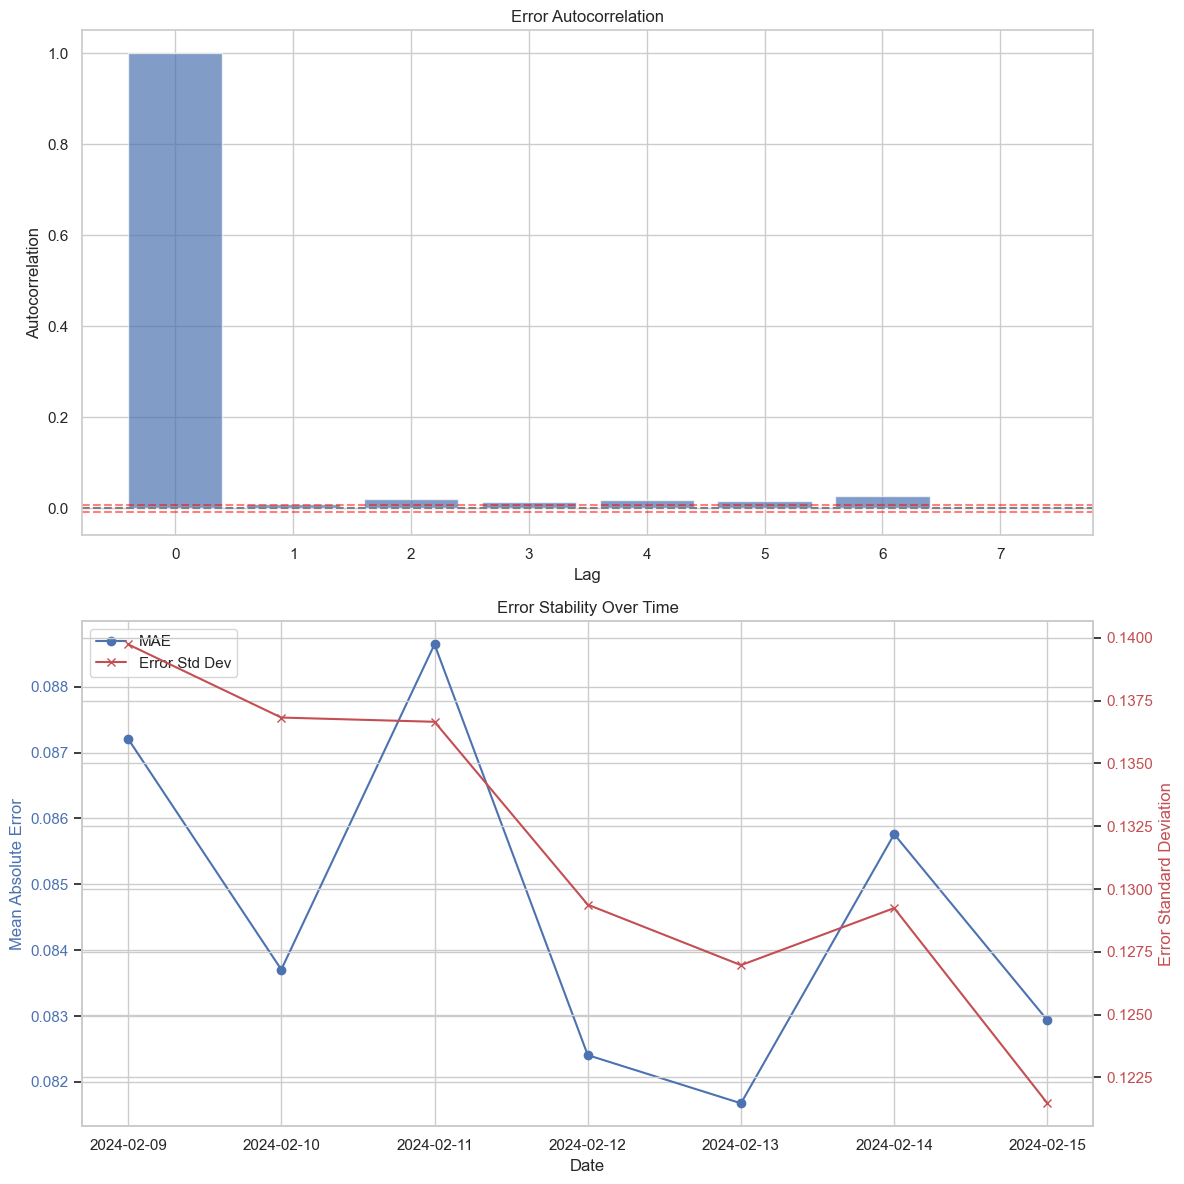

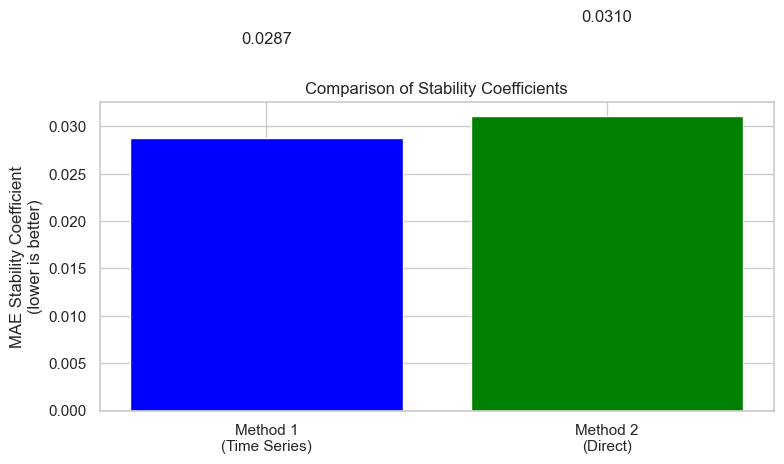


=== RUNNING MODEL WITHOUT 9 FEATURES ===
Processing dataset: train.csv
Features being dropped: ['price_lag_1d', 'price_lag_7d', 'price_lag_30d', 'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d']
Loading data...
Dropping column: price_lag_1d
Dropping column: price_lag_7d
Dropping column: price_lag_30d
Dropping column: rolling_mean_7d
Dropping column: rolling_max_7d
Dropping column: rolling_min_7d
Dropping column: rolling_mean_14d
Dropping column: rolling_max_14d
Dropping column: rolling_min_14d
Test set contains 7 unique dates.


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing days:  14%|█▍        | 1/7 [00:52<05:17, 52.84s/it]c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will 

Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Model_without_pricelag1d_pricelag7d_and_7_more\xgboost_results.csv with location data
Daily metrics saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Model_without_pricelag1d_pricelag7d_and_7_more\xgboost_results_daily_metrics.csv
Feature importance saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Model_without_pricelag1d_pricelag7d_and_7_more\xgboost_results_feature_importance.csv

===== DAY-BY-DAY XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.1710
MAE: 0.0989
R²: 0.9648
MAPE: 35.5307%
Explained Variance: 0.9648
Median Abs Error: 0.0714

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.177353 0.102170 38.912571       7864
2024-02-10 0.189150 0.106058 32.843886       7864
2024-02-11 0.167393 0.095578 35.670614       7864
2024-02-12 0.165132 0.096183 33.998704       7864
2024-02-13 0.163856 0.096616 35.561885       7864
2024

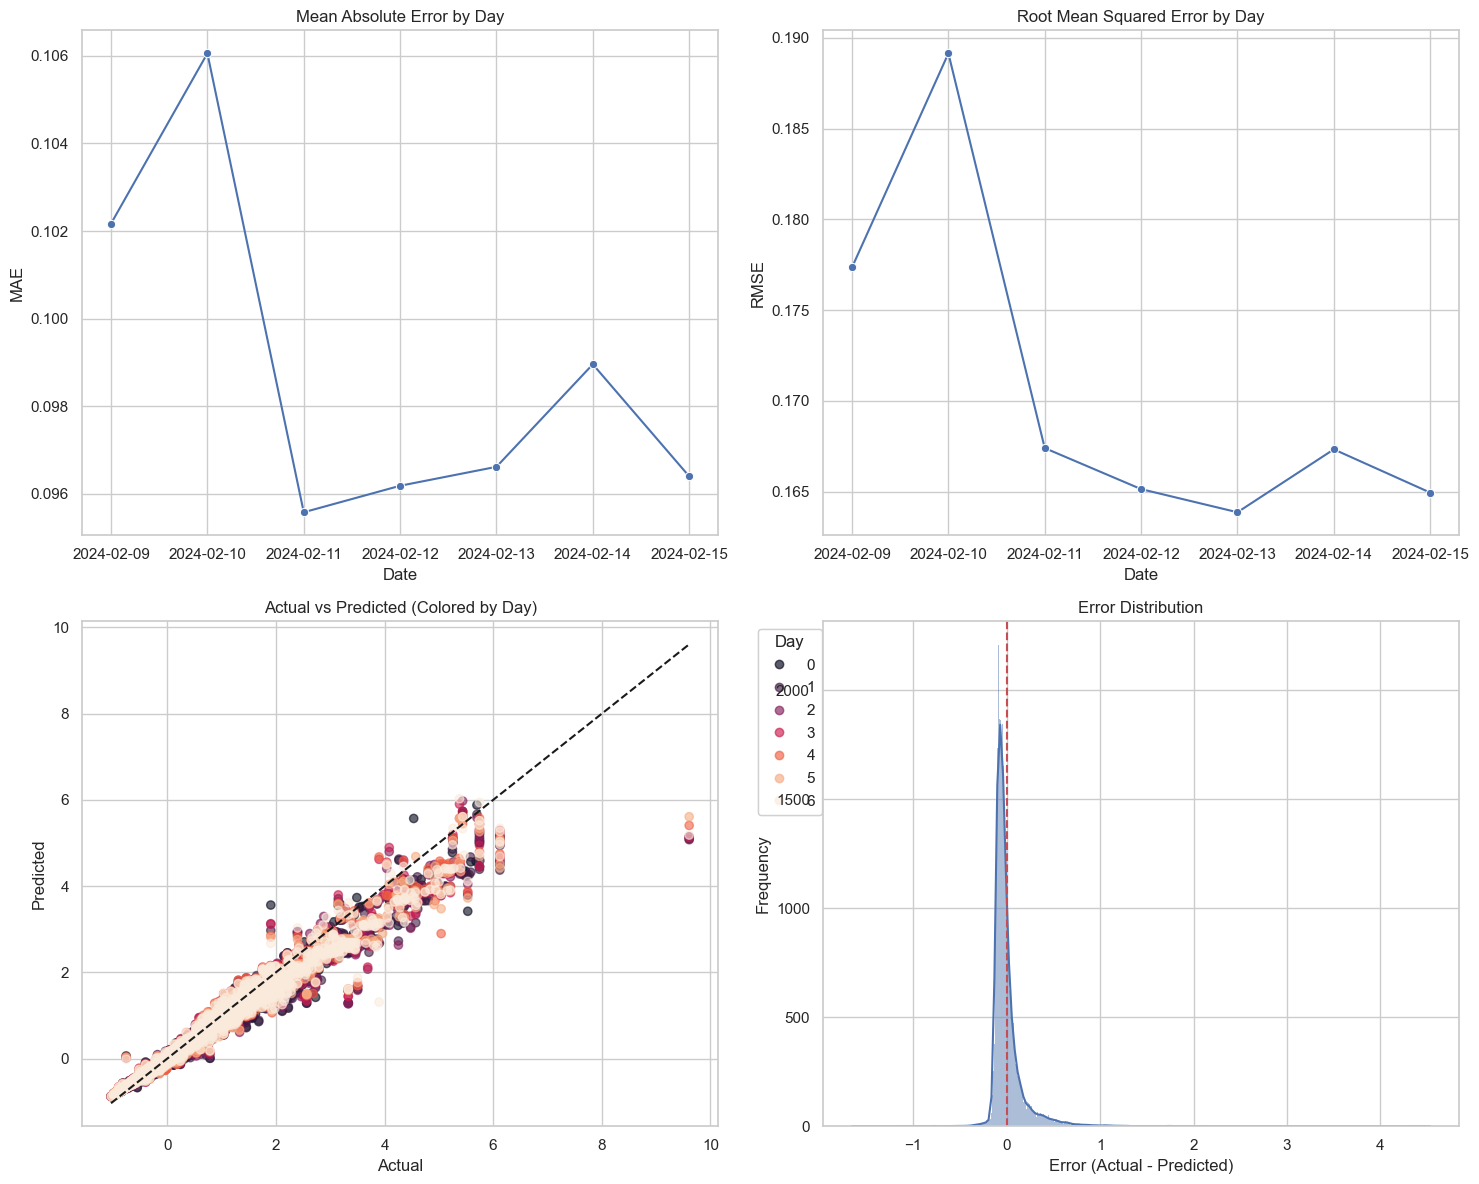

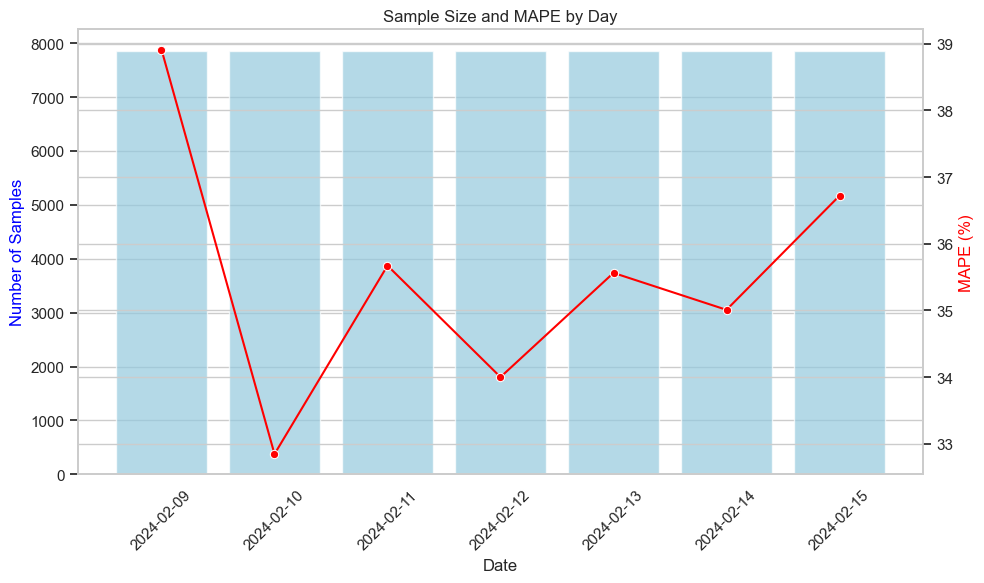

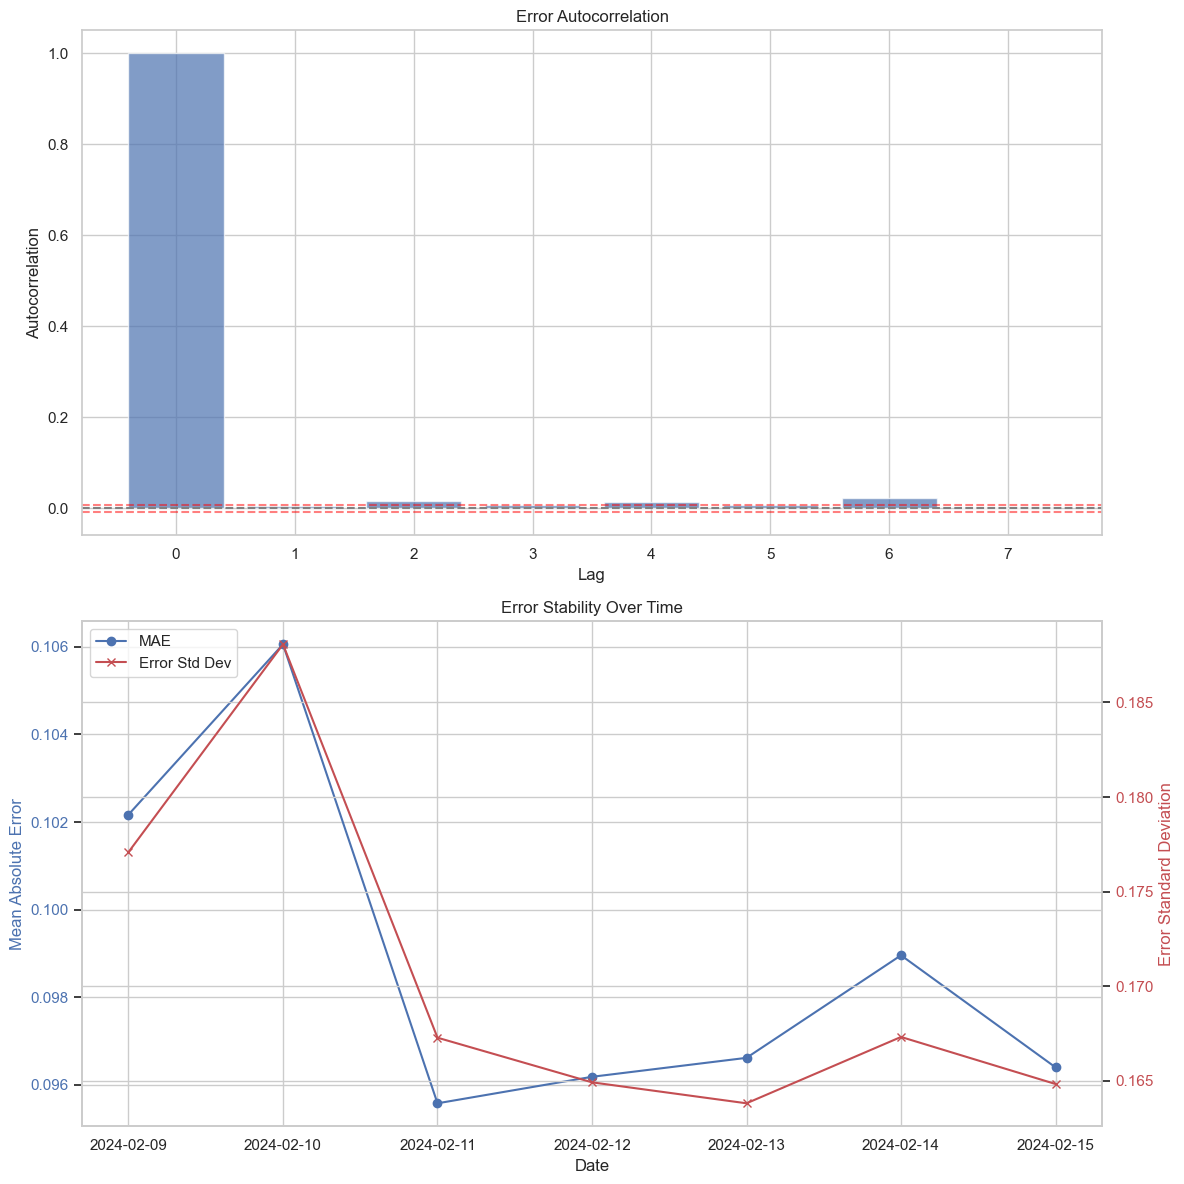

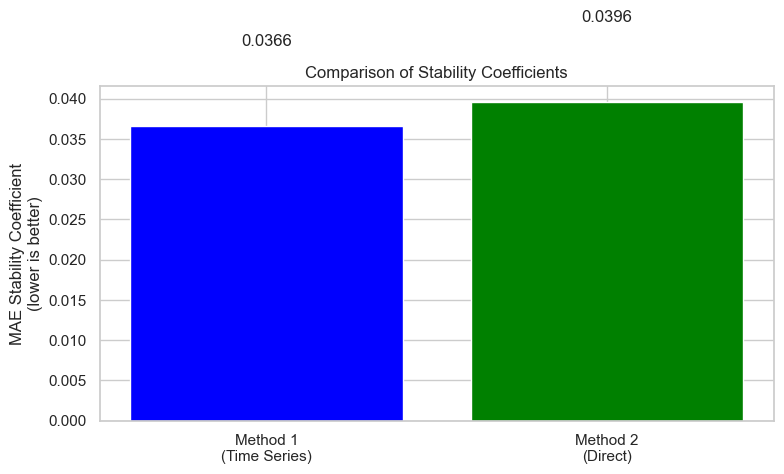


=== PERFORMANCE COMPARISON ===
Features dropped: price_lag_1d, price_lag_7d, price_lag_30d, rolling_mean_7d, rolling_max_7d, rolling_min_7d, rolling_mean_14d, rolling_max_14d, rolling_min_14d
Metric               Baseline        Ablation        Difference      % Change       
rmse                 0.131949        0.170952        0.039003        29.56          %
mae                  0.084619        0.098852        0.014232        16.82          %
r2                   0.979007        0.964761        0.014245        1.46           %
mape                 25.412465       35.530668       10.118203       39.82          %


In [11]:
# Example usage
if __name__ == "__main__":
    # # Simple example with defaults
    # results = run_ablation_experiment(
    #     subset_name="poorest_neighborhoods_subset", 
    #     test_period="test_feb"
    # )
    
    # Example of running multiple experiments in a loop
    subsets = ["top_price_changers_subset"]#, "richest_neighborhoods_subset"]
    test_periods = ["test_feb"]
    
    all_results = {}
    for subset in subsets:
        all_results[subset] = {}
        for period in test_periods:
            print(f"\n\n========= TESTING {subset} - {period} =========")
            all_results[subset][period] = run_ablation_experiment(subset, period)

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import os
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

def run_enhanced_spatial_analysis(results_path, geojson_path, output_dir):
    """
    Run an enhanced spatial analysis with clear, actionable insights
    
    Parameters:
    results_path: Path to naive baseline results CSV
    geojson_path: Path to Paris neighborhoods GeoJSON file
    output_dir: Directory to save output visualizations
    """
    print("Running enhanced spatial analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    neighborhoods = gpd.read_file(geojson_path)
    
    # 2. Create GeoDataFrame from results
    if 'longitude' in results_df.columns and 'latitude' in results_df.columns:
        # Clean data - remove rows with missing coordinates
        results_df = results_df.dropna(subset=['longitude', 'latitude'])
        
        # Convert coordinates to float if needed
        results_df['longitude'] = results_df['longitude'].astype(float)
        results_df['latitude'] = results_df['latitude'].astype(float)
        
        # Create geometry
        geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
        results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
        print(f"Created GeoDataFrame with {len(results_gdf)} points")
    else:
        raise ValueError("Results file missing longitude/latitude coordinates")
    
    # 3. Ensure same CRS for both datasets
    if neighborhoods.crs != results_gdf.crs:
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # 4. Spatial join to assign neighborhoods
    try:
        # Try with newer geopandas versions
        results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # Try with older geopandas versions
            results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Fallback to simple approach
            print("Spatial join failed - using simpler approach")
            results_with_neighborhoods = results_gdf.copy()
            results_with_neighborhoods['index_right'] = None
            results_with_neighborhoods['neighbourhood'] = None
    
    # 5. Ensure we have a neighborhood column
    if 'neighbourhood' not in results_with_neighborhoods.columns:
        # Look for another neighborhood column
        neighborhood_cols = [col for col in results_with_neighborhoods.columns if 'neighbo' in col.lower()]
        if neighborhood_cols:
            results_with_neighborhoods['neighbourhood'] = results_with_neighborhoods[neighborhood_cols[0]]
        else:
            print("Warning: No neighborhood column identified")
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 6. Calculate distance to city center (in kilometers)
    paris_center = Point(2.3522, 48.8566)  # Approximate center of Paris
    results_with_neighborhoods['dist_to_center_km'] = results_with_neighborhoods.geometry.apply(
        lambda x: paris_center.distance(x) * 111.32  # Approximate conversion to km
    )
    
    # 7. Calculate neighborhood-level metrics
    print("Calculating neighborhood metrics...")
    neighborhood_metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
        'abs_error': ['mean', 'median', 'std'],
        'error': ['mean', 'std'],
        'pct_error': ['mean', 'std'],
        'price': ['mean', 'median', 'std', 'count'],
        'dist_to_center_km': 'mean'
    })
    
    # Flatten column names
    neighborhood_metrics.columns = ['_'.join(col).strip('_') for col in neighborhood_metrics.columns.values]
    
    # Rename for clarity
    neighborhood_metrics = neighborhood_metrics.rename(columns={
        'abs_error_mean': 'mae',
        'abs_error_median': 'median_abs_error',
        'abs_error_std': 'error_volatility',
        'pct_error_mean': 'mape',
        'price_count': 'listing_count',
        'dist_to_center_km_mean': 'avg_distance_to_center'
    })
    
    # Filter out neighborhoods with too few listings
    min_listings = 5
    filtered_metrics = neighborhood_metrics[neighborhood_metrics['listing_count'] >= min_listings].copy()
    
    # 8. Create comprehensive spatial visualizations
    print("Creating visualizations...")
    
    # 8.1 Create main error map with key insights
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'mae', 
        'Mean Absolute Error by Neighborhood',
        os.path.join(output_dir, 'error_map.png')
    )
    
    # 8.2 Create map showing bias (over/under prediction)
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'error_mean', 
        'Prediction Bias by Neighborhood (+ = Underestimated, - = Overestimated)',
        os.path.join(output_dir, 'bias_map.png'),
        cmap='RdBu'
    )
    
    # 8.3 Create map showing error volatility
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'error_volatility', 
        'Error Volatility by Neighborhood',
        os.path.join(output_dir, 'volatility_map.png')
    )
    
    # 8.4 Create multi-panel analysis of key relationships
    create_multi_panel_analysis(filtered_metrics, os.path.join(output_dir, 'spatial_relationships.png'))
    
    # 8.5 Create scatterplot matrix
    create_scatterplot_matrix(filtered_metrics, os.path.join(output_dir, 'scatterplot_matrix.png'))
    
    # 9. Calculate error vs distance relationship
    dist_error_corr, dist_error_p = pearsonr(
        results_with_neighborhoods['dist_to_center_km'],
        results_with_neighborhoods['abs_error']
    )
    
    # 10. Create distance vs error analysis
    create_distance_analysis(
        results_with_neighborhoods,
        os.path.join(output_dir, 'distance_analysis.png')
    )
    
    # 11. Cluster neighborhoods by error patterns
    n_clusters = min(5, len(filtered_metrics))
    cluster_features = ['mae', 'error_mean', 'mape', 'price_mean', 'avg_distance_to_center']
    
    # Scale the data for clustering
    from sklearn.preprocessing import StandardScaler
    X = filtered_metrics[cluster_features].copy()
    X = StandardScaler().fit_transform(X)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    filtered_metrics['cluster'] = kmeans.fit_predict(X)
    
    # Create neighborhood cluster map
    create_cluster_map(
        neighborhoods,
        filtered_metrics,
        os.path.join(output_dir, 'neighborhood_clusters.png')
    )
    
    # 12. Create neighborhood performance table
    # Table of best and worst neighborhoods
    best_neighborhoods = filtered_metrics.sort_values('mae').head(5)
    worst_neighborhoods = filtered_metrics.sort_values('mae', ascending=False).head(5)
    
    performance_table = pd.concat([
        best_neighborhoods.reset_index()[['neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']],
        worst_neighborhoods.reset_index()[['neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']]
    ])
    performance_table['category'] = ['Best'] * 5 + ['Worst'] * 5
    performance_table = performance_table[['category', 'neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']]
    
    # Save to CSV
    performance_table.to_csv(os.path.join(output_dir, 'neighborhood_performance.csv'), index=False)
    
    # Save all metrics
    filtered_metrics.to_csv(os.path.join(output_dir, 'all_neighborhood_metrics.csv'))
    
    # 13. Print key insights
    print("\n--- KEY SPATIAL INSIGHTS ---")
    print(f"Total neighborhoods analyzed: {len(filtered_metrics)}")
    print(f"Best performing neighborhood: {best_neighborhoods.index[0]} (MAE = {best_neighborhoods['mae'].iloc[0]:.4f})")
    print(f"Worst performing neighborhood: {worst_neighborhoods.index[0]} (MAE = {worst_neighborhoods['mae'].iloc[0]:.4f})")
    
    # Calculate correlations between metrics
    corr = filtered_metrics[['mae', 'error_mean', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']].corr()
    
    # Print key correlations
    print("\n--- KEY CORRELATIONS ---")
    print(f"Price vs Error (MAE): {corr.loc['price_mean', 'mae']:.4f}")
    print(f"Distance to Center vs Error: {corr.loc['avg_distance_to_center', 'mae']:.4f}")
    print(f"Listing Count vs Error: {corr.loc['listing_count', 'mae']:.4f}")
    
    # Direct distance-error relationship from points
    print(f"Point-level Distance-Error Correlation: {dist_error_corr:.4f} (p-value: {dist_error_p:.4f})")
    
    # Interpret key findings
    print("\n--- INTERPRETATION ---")
    
    # Price-error relationship
    price_corr = corr.loc['price_mean', 'mae']
    if abs(price_corr) > 0.7:
        print(f"Very strong {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
        if price_corr > 0:
            print("- Higher-priced neighborhoods have significantly larger prediction errors")
            print("- Model struggles most with luxury/premium areas")
        else:
            print("- Higher-priced neighborhoods have significantly lower prediction errors")
            print("- Model performs better in premium/luxury areas")
    elif abs(price_corr) > 0.5:
        print(f"Strong {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
    elif abs(price_corr) > 0.3:
        print(f"Moderate {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
    else:
        print(f"Weak correlation between price and error ({price_corr:.2f})")
        print("- Neighborhood price level is not a strong predictor of model performance")
    
    # Distance-error relationship
    dist_corr = corr.loc['avg_distance_to_center', 'mae']
    if abs(dist_corr) > 0.5:
        print(f"\nStrong {'positive' if dist_corr > 0 else 'negative'} correlation between distance to center and error ({dist_corr:.2f})")
        if dist_corr > 0:
            print("- Neighborhoods further from the city center have larger prediction errors")
            print("- Model performs worse in peripheral areas")
        else:
            print("- Central neighborhoods have larger prediction errors")
            print("- Model performs better in peripheral areas")
    elif abs(dist_corr) > 0.3:
        print(f"\nModerate {'positive' if dist_corr > 0 else 'negative'} correlation between distance to center and error ({dist_corr:.2f})")
    else:
        print(f"\nWeak correlation between distance to center and error ({dist_corr:.2f})")
        print("- Location relative to city center doesn't strongly affect prediction accuracy")
    
    # Bias analysis (over/under prediction)
    avg_error = filtered_metrics['error_mean'].mean()
    if abs(avg_error) > 0.05:
        bias_direction = "underestimates" if avg_error > 0 else "overestimates"
        print(f"\nThe model generally {bias_direction} prices (average error: {avg_error:.4f})")
        
        # Check if bias is consistent across neighborhoods
        bias_std = filtered_metrics['error_mean'].std()
        if bias_std < abs(avg_error) * 0.5:
            print("- This bias is fairly consistent across neighborhoods")
        else:
            most_under = filtered_metrics.sort_values('error_mean', ascending=False).index[0]
            most_over = filtered_metrics.sort_values('error_mean', ascending=True).index[0]
            print(f"- Bias varies considerably by neighborhood")
            print(f"- Most underestimated neighborhood: {most_under}")
            print(f"- Most overestimated neighborhood: {most_over}")
    
    print(f"\nResults saved to {output_dir}")
    
    return {
        'neighborhood_metrics': filtered_metrics,
        'correlations': corr,
        'distance_correlation': dist_error_corr
    }

def create_error_map(neighborhoods, metrics, column, title, output_path, cmap='Reds'):
    """Create a detailed choropleth map with key insights"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create the map
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    map_data.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        legend_kwds={
            'label': column.replace('_', ' ').title(),
            'orientation': 'horizontal',
            'shrink': 0.5,
            'pad': 0.05
        }
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Label top 3 and bottom 3 neighborhoods
    if column in metrics.columns:
        # Top 3 highest values
        top3 = metrics.sort_values(column, ascending=False).head(3)
        for idx, row in top3.iterrows():
            # Find this neighborhood in the map data
            hood_geom = map_data[map_data['neighbourhood'] == idx]
            if not hood_geom.empty:
                centroid = hood_geom.geometry.centroid.iloc[0]
                ax.annotate(
                    idx,
                    (centroid.x, centroid.y),
                    color='black',
                    fontweight='bold',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
                )
        
        # Top 3 lowest values
        bottom3 = metrics.sort_values(column).head(3)
        for idx, row in bottom3.iterrows():
            # Find this neighborhood in the map data
            hood_geom = map_data[map_data['neighbourhood'] == idx]
            if not hood_geom.empty:
                centroid = hood_geom.geometry.centroid.iloc[0]
                ax.annotate(
                    idx,
                    (centroid.x, centroid.y),
                    color='black',
                    fontweight='bold',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
                )
    
    # Add title and styling
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    
    # Add key statistics box
    if column in metrics.columns:
        corr_with_price = metrics[[column, 'price_mean']].corr().iloc[0, 1]
        corr_with_dist = metrics[[column, 'avg_distance_to_center']].corr().iloc[0, 1]
        
        stats_text = (
            f"Correlation with price: {corr_with_price:.2f}\n"
            f"Correlation with distance: {corr_with_dist:.2f}\n"
            f"Best area: {metrics[column].idxmin()}\n"
            f"Worst area: {metrics[column].idxmax()}"
        )
        
        # Place text box in bottom right
        plt.figtext(
            0.92, 0.05, 
            stats_text,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            fontsize=10,
            ha='right'
        )
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_multi_panel_analysis(metrics, output_path):
    """Create a multi-panel figure showing key spatial relationships"""
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    
    # Panel 1: Price vs. Error
    ax1 = fig.add_subplot(gs[0, 0])
    sns.scatterplot(
        x='price_mean',
        y='mae',
        size='listing_count',
        hue='avg_distance_to_center',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax1
    )
    
    # Add correlation
    corr = metrics[['price_mean', 'mae']].corr().iloc[0, 1]
    ax1.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['mae'] > metrics['mae'].mean() + 1.5 * metrics['mae'].std() or
            row['price_mean'] > metrics['price_mean'].mean() + 1.5 * metrics['price_mean'].std()):
            ax1.annotate(
                idx,
                (row['price_mean'], row['mae']),
                fontsize=9,
                alpha=0.8
            )
    
    ax1.set_title('Price vs. Error by Neighborhood', fontsize=14)
    ax1.set_xlabel('Average Price', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Distance vs. Error
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(
        x='avg_distance_to_center',
        y='mae',
        size='listing_count',
        hue='price_mean',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax2
    )
    
    # Add correlation
    corr = metrics[['avg_distance_to_center', 'mae']].corr().iloc[0, 1]
    ax2.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['mae'] > metrics['mae'].mean() + 1.5 * metrics['mae'].std() or
            row['avg_distance_to_center'] > metrics['avg_distance_to_center'].mean() + 1.5 * metrics['avg_distance_to_center'].std()):
            ax2.annotate(
                idx,
                (row['avg_distance_to_center'], row['mae']),
                fontsize=9,
                alpha=0.8
            )
    
    ax2.set_title('Distance from Center vs. Error', fontsize=14)
    ax2.set_xlabel('Average Distance from City Center (km)', fontsize=12)
    ax2.set_ylabel('Mean Absolute Error', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Error vs. Error Volatility
    ax3 = fig.add_subplot(gs[1, 0])
    sns.scatterplot(
        x='mae',
        y='error_volatility',
        size='listing_count',
        hue='price_mean',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax3
    )
    
    # Add correlation
    corr = metrics[['mae', 'error_volatility']].corr().iloc[0, 1]
    ax3.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['error_volatility'] > metrics['error_volatility'].mean() + 1.5 * metrics['error_volatility'].std()):
            ax3.annotate(
                idx,
                (row['mae'], row['error_volatility']),
                fontsize=9,
                alpha=0.8
            )
    
    ax3.set_title('Error vs. Error Volatility', fontsize=14)
    ax3.set_xlabel('Mean Absolute Error', fontsize=12)
    ax3.set_ylabel('Error Volatility (Std Dev)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Bias Analysis (Error Mean)
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Create a centered colormap for bias
    error_mean_data = metrics['error_mean']
    max_abs_error = max(abs(error_mean_data.min()), abs(error_mean_data.max()))
    error_norm = plt.Normalize(-max_abs_error, max_abs_error)
    
    scatter = ax4.scatter(
        metrics['price_mean'],
        metrics['avg_distance_to_center'],
        s=metrics['listing_count'] * 2,
        c=metrics['error_mean'],
        cmap='RdBu_r',
        norm=error_norm,
        alpha=0.7
    )
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Prediction Bias (+ = Underestimated, - = Overestimated)', fontsize=10)
    
    # Label neighborhoods with extreme bias
    for idx, row in metrics.iterrows():
        if (abs(row['error_mean']) > abs(metrics['error_mean']).mean() + 1.5 * abs(metrics['error_mean']).std()):
            ax4.annotate(
                idx,
                (row['price_mean'], row['avg_distance_to_center']),
                fontsize=9,
                alpha=0.8
            )
    
    ax4.set_title('Prediction Bias by Price and Location', fontsize=14)
    ax4.set_xlabel('Average Price', fontsize=12)
    ax4.set_ylabel('Distance from City Center (km)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # Add overall title
    fig.suptitle('Spatial Patterns in Prediction Errors', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_scatterplot_matrix(metrics, output_path):
    """Create a scatterplot matrix of key metrics"""
    # Select features for the matrix
    features = ['mae', 'error_mean', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']
    
    # Create scatterplot matrix
    sns.set(style="ticks")
    sns.pairplot(
        metrics[features],
        diag_kind="kde",
        plot_kws={"alpha": 0.6}
    )
    
    plt.suptitle('Relationships Between Key Neighborhood Metrics', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_distance_analysis(results_gdf, output_path):
    """Create detailed analysis of distance-error relationship"""
    # Create distance bins
    max_dist = results_gdf['dist_to_center_km'].max()
    results_gdf['dist_bin'] = pd.cut(
        results_gdf['dist_to_center_km'],
        bins=10,
        include_lowest=True,
        labels=False
    )
    
    # Calculate stats by distance bin
    dist_stats = results_gdf.groupby('dist_bin').agg({
        'dist_to_center_km': ['mean', 'count'],
        'abs_error': ['mean', 'std', 'median'],
        'error': ['mean', 'std'],
        'price': ['mean', 'std'],
        'pct_error': 'mean'
    })
    
    # Flatten column names
    dist_stats.columns = ['_'.join(col).strip('_') for col in dist_stats.columns.values]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot distance vs error
    ax1.errorbar(
        dist_stats['dist_to_center_km_mean'],
        dist_stats['abs_error_mean'],
        yerr=dist_stats['abs_error_std'],
        fmt='o-',
        capsize=5,
        ecolor='gray',
        alpha=0.7
    )
    
    # Add sample size as text
    for i, row in dist_stats.iterrows():
        ax1.annotate(
            f"n={int(row['dist_to_center_km_count'])}",
            (row['dist_to_center_km_mean'], row['abs_error_mean']),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            fontsize=8
        )
    
    # Add correlation line
    x = results_gdf['dist_to_center_km']
    y = results_gdf['abs_error']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(np.sort(x.unique()), p(np.sort(x.unique())), "r--", alpha=0.7)
    
    # Calculate correlation
    corr, p_value = pearsonr(x, y)
    ax1.annotate(
        f"Correlation: {corr:.2f} (p={p_value:.4f})",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    ax1.set_title('Error vs. Distance from City Center', fontsize=14)
    ax1.set_xlabel('Distance from Center (km)', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Create spatial visualization of error by distance
    # Project to Web Mercator for mapping
    results_projected = results_gdf.to_crs('EPSG:3857')
    paris_center_projected = gpd.GeoDataFrame([1], geometry=[Point(2.3522, 48.8566)], crs="EPSG:4326").to_crs('EPSG:3857')
    
    # Plot on map
    scatter = ax2.scatter(
        results_projected.geometry.x,
        results_projected.geometry.y,
        c=results_projected['abs_error'],
        cmap='hot_r',
        alpha=0.6,
        s=20
    )
    
    # Add center point
    ax2.scatter(
        paris_center_projected.geometry.x,
        paris_center_projected.geometry.y,
        marker='*',
        s=300,
        color='blue',
        edgecolor='white',
        linewidth=1,
        zorder=10
    )
    
    # Draw distance rings
    for dist_km in [2, 4, 6, 8]:
        # Convert km to meters
        dist_m = dist_km * 1000
        circle = plt.Circle(
            (paris_center_projected.geometry.x, paris_center_projected.geometry.y),
            dist_m,
            fill=False,
            color='gray',
            linestyle='--',
            alpha=0.7
        )
        ax2.add_patch(circle)
        # Add label
        angle = np.pi/4  # 45 degrees
        x = paris_center_projected.geometry.x.iloc[0] + dist_m * np.cos(angle)
        y = paris_center_projected.geometry.y.iloc[0] + dist_m * np.sin(angle)
        ax2.annotate(
            f"{dist_km} km",
            (x, y),
            fontsize=9,
            ha='center',
            va='center',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7)
        )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Absolute Error', fontsize=12)
    
    # Add basemap
    try:
        ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
    except:
        print("Warning: Could not add basemap to distance analysis")
    
    ax2.set_title('Spatial Distribution of Errors', fontsize=14)
    ax2.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_map(neighborhoods, metrics, output_path):
    """Create a map showing neighborhood clusters based on error patterns"""
    # Join cluster information to neighborhoods
    map_data = neighborhoods.merge(metrics[['cluster']], left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot neighborhoods colored by cluster
    map_data.plot(
        column='cluster',
        categorical=True,
        ax=ax,
        legend=True,
        cmap='tab10',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        legend_kwds={
            'title': 'Cluster',
            'loc': 'lower left'
        }
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Create cluster summary statistics
    cluster_stats = metrics.groupby('cluster').agg({
        'mae': 'mean',
        'error_mean': 'mean',
        'mape': 'mean',
        'price_mean': 'mean',
        'avg_distance_to_center': 'mean',
        'listing_count': 'sum'
    })
    
    # Add textbox with cluster characteristics
    cluster_desc = ""
    for cluster, row in cluster_stats.iterrows():
        # Determine key characteristics of this cluster
        price_level = "High" if row['price_mean'] > metrics['price_mean'].mean() else "Low"
        error_level = "High" if row['mae'] > metrics['mae'].mean() else "Low"
        location = "Central" if row['avg_distance_to_center'] < metrics['avg_distance_to_center'].mean() else "Peripheral"
        
        cluster_desc += f"Cluster {cluster}: {price_level} price, {error_level} error, {location}\n"
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        cluster_desc,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    # Add title and styling
    ax.set_title('Neighborhood Clusters Based on Error Patterns', fontsize=14)
    ax.set_axis_off()
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save cluster descriptions to CSV
    cluster_stats.to_csv(os.path.join(os.path.dirname(output_path), 'cluster_characteristics.csv'))

In [ ]:
# Example usage
if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Model_baseline\xgboost_results.csv"
    geojson_path = r"C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Spatial1"
    
    # Run analysis
    run_enhanced_spatial_analysis(results_path, geojson_path, output_dir)

Running enhanced spatial analysis...
Loading data...


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mvk\\Documents\\DATA_school\\thesis\\Output\\Model_baseline\\xgboost_results.csv'

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import os
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def run_simplified_price_analysis(results_path, geojson_path, output_dir):
    """
    Run simplified but robust spatial analysis of predicted vs actual prices
    
    Parameters:
    results_path: Path to naive baseline results CSV
    geojson_path: Path to Paris neighborhoods GeoJSON file
    output_dir: Directory to save output visualizations
    """
    print("Running simplified price spatial analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    neighborhoods = gpd.read_file(geojson_path)
    
    # 2. Basic data preparation
    # Clean data - remove rows with missing values
    results_df = results_df.dropna(subset=['longitude', 'latitude', 'price', 'predicted'])
    
    # Convert coordinates to float if needed
    results_df['longitude'] = results_df['longitude'].astype(float)
    results_df['latitude'] = results_df['latitude'].astype(float)
    
    # Create geometry
    geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
    results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
    print(f"Created GeoDataFrame with {len(results_gdf)} points")
    
    # 3. Ensure same CRS for both datasets
    if neighborhoods.crs != results_gdf.crs:
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # 4. Spatial join to assign neighborhoods
    try:
        # Try with newer geopandas versions
        results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # Try with older geopandas versions
            results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Fallback to simple approach
            print("Spatial join failed - using simpler approach")
            results_with_neighborhoods = results_gdf.copy()
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 5. Ensure we have a neighborhood column
    if 'neighbourhood' not in results_with_neighborhoods.columns:
        # Look for another neighborhood column
        neighborhood_cols = [col for col in results_with_neighborhoods.columns if 'neighbo' in col.lower()]
        if neighborhood_cols:
            results_with_neighborhoods['neighbourhood'] = results_with_neighborhoods[neighborhood_cols[0]]
        else:
            print("Warning: No neighborhood column identified")
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 6. Calculate neighborhood-level price metrics
    print("Calculating neighborhood price metrics...")
    neighborhood_metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
        'price': ['mean', 'median', 'std', 'count'],
        'predicted': ['mean', 'std'],
        'abs_error': 'mean'
    })
    
    # Flatten column names
    neighborhood_metrics.columns = ['_'.join(col).strip('_') for col in neighborhood_metrics.columns.values]
    
    # Rename for clarity
    neighborhood_metrics = neighborhood_metrics.rename(columns={
        'price_count': 'listing_count',
        'abs_error_mean': 'mae'
    })
    
    # Calculate price prediction bias
    neighborhood_metrics['prediction_bias'] = neighborhood_metrics['predicted_mean'] - neighborhood_metrics['price_mean']
    neighborhood_metrics['prediction_bias_pct'] = (neighborhood_metrics['prediction_bias'] / neighborhood_metrics['price_mean']) * 100
    
    # Filter out neighborhoods with too few listings
    min_listings = 5
    filtered_metrics = neighborhood_metrics[neighborhood_metrics['listing_count'] >= min_listings].copy()
    
    # 7. Create basic but robust visualizations
    print("Creating visualizations...")
    
    # 7.1 Create actual vs predicted prices scatter plot
    plot_price_comparison(filtered_metrics, os.path.join(output_dir, 'price_comparison.png'))
    
    # 7.2 Create error map
    plot_neighborhood_error_map(neighborhoods, filtered_metrics, os.path.join(output_dir, 'neighborhood_error.png'))
    
    # 7.3 Create bias map (over/under estimation)
    plot_neighborhood_bias_map(neighborhoods, filtered_metrics, os.path.join(output_dir, 'neighborhood_bias.png'))
    
    # 7.4 Create simple price histogram for top neighborhoods
    plot_price_histograms(results_with_neighborhoods, os.path.join(output_dir, 'price_histograms.png'))
    
    # 7.5 Create scatter map of all points
    plot_point_scatter_map(results_with_neighborhoods, os.path.join(output_dir, 'price_points_map.png'))
    
    # 8. Calculate overall correlations
    price_corr = pearsonr(filtered_metrics['price_mean'], filtered_metrics['predicted_mean'])[0]
    
    # Print key insights
    print("\n--- KEY PRICE INSIGHTS ---")
    print(f"Total neighborhoods analyzed: {len(filtered_metrics)}")
    print(f"Correlation between actual and predicted prices: {price_corr:.4f}")
    
    # Most over/under predicted neighborhoods
    over_predicted = filtered_metrics.sort_values('prediction_bias_pct', ascending=False).head(3)
    under_predicted = filtered_metrics.sort_values('prediction_bias_pct').head(3)
    
    print("\nMost over-predicted neighborhoods (model predicts too high):")
    for idx, row in over_predicted.iterrows():
        print(f"- {idx}: {row['prediction_bias_pct']:.1f}% higher than actual")
    
    print("\nMost under-predicted neighborhoods (model predicts too low):")
    for idx, row in under_predicted.iterrows():
        print(f"- {idx}: {row['prediction_bias_pct']:.1f}% lower than actual")
    
    # Save metrics to CSV for further analysis
    filtered_metrics.to_csv(os.path.join(output_dir, 'neighborhood_price_metrics.csv'))
    
    print(f"Results saved to {output_dir}")
    return filtered_metrics

def plot_price_comparison(metrics, output_path):
    """Create a simple scatter plot comparing actual vs predicted prices"""
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot
    sns.scatterplot(
        x='price_mean',
        y='predicted_mean',
        size='listing_count',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics
    )
    
    # Add diagonal line (perfect prediction)
    lims = [
        min(metrics['price_mean'].min(), metrics['predicted_mean'].min()),
        max(metrics['price_mean'].max(), metrics['predicted_mean'].max())
    ]
    plt.plot(lims, lims, 'r--', alpha=0.7)
    
    # Add correlation
    corr = pearsonr(metrics['price_mean'], metrics['predicted_mean'])[0]
    plt.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        # Label neighborhoods with large differences
        if abs(row['price_mean'] - row['predicted_mean']) > metrics['price_mean'].std():
            plt.annotate(
                idx,
                (row['price_mean'], row['predicted_mean']),
                fontsize=9,
                alpha=0.8
            )
    
    plt.title('Actual vs. Predicted Average Prices by Neighborhood', fontsize=14)
    plt.xlabel('Actual Average Price', fontsize=12)
    plt.ylabel('Predicted Average Price', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_neighborhood_error_map(neighborhoods, metrics, output_path):
    """Create a simplified map showing MAE by neighborhood"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    map_data.plot(
        column='mae',
        ax=ax,
        legend=True,
        cmap='Reds',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7
    )
    
    # Add basemap (safely)
    try:
        # Convert to Web Mercator for basemap
        map_data = map_data.to_crs('EPSG:3857')
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        # Fallback to simpler map without basemap
        ax.set_axis_off()
    
    # Add title
    ax.set_title('Mean Absolute Error by Neighborhood', fontsize=14)
    
    # Add key statistics
    best_hood = metrics['mae'].idxmin()
    worst_hood = metrics['mae'].idxmax()
    
    stats_text = (
        f"Best neighborhood: {best_hood} (MAE: {metrics.loc[best_hood, 'mae']:.2f})\n"
        f"Worst neighborhood: {worst_hood} (MAE: {metrics.loc[worst_hood, 'mae']:.2f})"
    )
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        stats_text,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_neighborhood_bias_map(neighborhoods, metrics, output_path):
    """Create a simplified map showing prediction bias by neighborhood"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    divnorm = plt.Normalize(vmin=-metrics['prediction_bias_pct'].abs().max(), 
                           vmax=metrics['prediction_bias_pct'].abs().max())
    
    map_data.plot(
        column='prediction_bias_pct',
        ax=ax,
        legend=True,
        cmap='RdBu',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        norm=divnorm
    )
    
    # Add basemap (safely)
    try:
        # Convert to Web Mercator for basemap
        map_data = map_data.to_crs('EPSG:3857')
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        # Fallback to simpler map without basemap
        ax.set_axis_off()
    
    # Add title
    ax.set_title('Price Prediction Bias by Neighborhood (%)', fontsize=14)
    
    # Add key statistics
    most_over = metrics['prediction_bias_pct'].idxmax()
    most_under = metrics['prediction_bias_pct'].idxmin()
    
    stats_text = (
        f"Most overestimated: {most_over} ({metrics.loc[most_over, 'prediction_bias_pct']:.1f}%)\n"
        f"Most underestimated: {most_under} ({metrics.loc[most_under, 'prediction_bias_pct']:.1f}%)"
    )
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        stats_text,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_price_histograms(results_gdf, output_path):
    """Create histograms of actual vs predicted prices for top neighborhoods"""
    # Select top 4 neighborhoods by listing count
    top_neighborhoods = results_gdf.groupby('neighbourhood').size().sort_values(ascending=False).head(4).index
    
    # Filter data
    filtered_data = results_gdf[results_gdf['neighbourhood'].isin(top_neighborhoods)]
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Plot distributions for each neighborhood
    for i, neighborhood in enumerate(top_neighborhoods):
        if i >= len(axes):
            break
            
        neighborhood_data = filtered_data[filtered_data['neighbourhood'] == neighborhood]
        
        # Plot actual prices
        sns.histplot(
            neighborhood_data['price'],
            color='blue',
            alpha=0.5,
            label='Actual',
            ax=axes[i],
            kde=True
        )
        
        # Plot predicted prices
        sns.histplot(
            neighborhood_data['predicted'],
            color='red',
            alpha=0.5,
            label='Predicted',
            ax=axes[i],
            kde=True
        )
        
        # Add annotation with key stats
        axes[i].annotate(
            f"n={len(neighborhood_data)}\nMAE: {neighborhood_data['abs_error'].mean():.2f}",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
            va='top'
        )
        
        axes[i].set_title(f'{neighborhood}', fontsize=14)
        axes[i].set_xlabel('Price', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].legend()
    
    # Add overall title
    fig.suptitle('Price Distributions: Actual vs. Predicted', fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_point_scatter_map(results_gdf, output_path):
    """Create a scatter map of all points colored by prediction accuracy"""
    # Calculate percentage error
    results_gdf['pct_error'] = (results_gdf['predicted'] - results_gdf['price']) / results_gdf['price'] * 100
    results_gdf['pct_error'] = results_gdf['pct_error'].clip(-100, 100)  # Clip extreme values
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Try to convert to appropriate CRS
    try:
        results_projected = results_gdf.to_crs('EPSG:3857')
    except:
        results_projected = results_gdf
    
    # Create scatter plot with diverging colormap
    divnorm = plt.Normalize(vmin=-50, vmax=50)
    
    # Plot points - using a simpler approach to avoid colorbar issues
    for category, color, label in [
        (results_projected['pct_error'] < -20, 'blue', 'Underestimated (>20%)'),
        ((results_projected['pct_error'] >= -20) & (results_projected['pct_error'] <= 20), 'green', 'Accurate (±20%)'),
        (results_projected['pct_error'] > 20, 'red', 'Overestimated (>20%)')
    ]:
        subset = results_projected[category]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            color=color,
            alpha=0.6,
            s=15,
            label=label
        )
    
    # Add basemap (safely)
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
    
    # Add title and legend
    ax.set_title('Spatial Distribution of Price Prediction Accuracy', fontsize=14)
    ax.legend(loc='upper right')
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
if __name__ == "__main__":
    # Define paths
    
    results_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Model_baseline\xgboost_results.csv"
    geojson_path = r"C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Spatial2"


    # Run analysis
    run_simplified_price_analysis(results_path, geojson_path, output_dir)

Running simplified price spatial analysis...
Loading data...
Created GeoDataFrame with 55048 points
Used 'predicate' parameter for spatial join
Calculating neighborhood price metrics...
Creating visualizations...

--- KEY PRICE INSIGHTS ---
Total neighborhoods analyzed: 20
Correlation between actual and predicted prices: 1.0000

Most over-predicted neighborhoods (model predicts too high):
- Luxembourg: -10.3% higher than actual
- Passy: -10.5% higher than actual
- Hôtel-de-Ville: -11.1% higher than actual

Most under-predicted neighborhoods (model predicts too low):
- Vaugirard: -17.6% lower than actual
- Entrepôt: -15.8% lower than actual
- Batignolles-Monceau: -15.3% lower than actual
Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Spatial2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

def run_simple_temporal_analysis(results_path, daily_metrics_path=None, output_dir=None):
    """
    Run a simple temporal analysis to understand how prediction errors vary over time
    
    Parameters:
    results_path: Path to naive baseline results CSV
    daily_metrics_path: Path to daily metrics CSV (if available)
    output_dir: Directory to save output visualizations
    """
    # Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    print("Running simple temporal analysis...")
    
    # Load results data
    results_df = pd.read_csv(results_path)
    
    # Ensure date is in datetime format
    results_df['date'] = pd.to_datetime(results_df['date'])
    
    # Extract day of week
    results_df['day_of_week'] = results_df['date'].dt.day_name()
    results_df['is_weekend'] = results_df['day_of_week'].isin(['Saturday', 'Sunday'])
    
    # 1. Analyze daily metrics if available
    if daily_metrics_path and os.path.exists(daily_metrics_path):
        daily_df = pd.read_csv(daily_metrics_path)
        daily_df['date'] = pd.to_datetime(daily_df['date'])
        daily_df['day_of_week'] = daily_df['date'].dt.day_name()
        daily_df['is_weekend'] = daily_df['day_of_week'].isin(['Saturday', 'Sunday'])
        
        # Plot daily metrics
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='date', y='mae', data=daily_df, marker='o', markersize=10)
        plt.title('Mean Absolute Error by Day', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add day of week labels
        for i, row in daily_df.iterrows():
            plt.annotate(
                row['day_of_week'][:3],  # First 3 letters of day name
                (row['date'], row['mae']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9
            )
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'daily_mae_trend.png'), dpi=300)
        plt.show()
        
        # Compare weekend vs weekday performance
        weekend_stats = daily_df.groupby('is_weekend').agg({
            'mae': 'mean',
            'rmse': 'mean',
            'mape': 'mean'
        })
        
        print("\n--- Weekend vs Weekday Performance ---")
        print(weekend_stats)
        
        # Plot weekend vs weekday comparison
        plt.figure(figsize=(10, 6))
        metrics = ['mae', 'rmse', 'mape']
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            sns.barplot(
                x=weekend_stats.index.map({True: 'Weekend', False: 'Weekday'}), 
                y=metric, 
                data=weekend_stats
            )
            plt.title(metric.upper())
            plt.xlabel('')
            plt.ylabel(metric.upper())
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'weekend_weekday_comparison.png'), dpi=300)
        plt.show()
    
    # 2. Analyze error patterns by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = results_df.groupby('day_of_week').agg({
        'abs_error': 'mean',
        'error': 'mean',
        'pct_error': 'mean',
        'listing_id': 'count'
    }).reindex(day_order).rename(columns={
        'abs_error': 'mae',
        'pct_error': 'mape',
        'listing_id': 'count'
    })
    
    print("\n--- Error by Day of Week ---")
    print(weekday_stats)
    
    # Plot error by day of week
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=weekday_stats.index, 
        y='mae', 
        data=weekday_stats,
        palette=['skyblue' if day not in ['Saturday', 'Sunday'] else 'salmon' for day in weekday_stats.index]
    )
    plt.title('Mean Absolute Error by Day of Week', fontsize=14)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    
    # Add count labels
    for i, count in enumerate(weekday_stats['count']):
        plt.text(
            i, 
            weekday_stats['mae'].iloc[i] / 2,
            f"n={count}",
            ha='center',
            color='white',
            fontweight='bold'
        )
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_by_day_of_week.png'), dpi=300)
    plt.show()
    
    # 3. Analyze error trends over prediction horizon
    if 'last_train_date' in results_df.columns:
        # Calculate days since last training point
        results_df['last_train_date'] = pd.to_datetime(results_df['last_train_date'])
        results_df['days_since_training'] = (results_df['date'] - results_df['last_train_date']).dt.days
        
        horizon_stats = results_df.groupby('days_since_training').agg({
            'abs_error': 'mean',
            'error': 'mean',
            'pct_error': 'mean',
            'listing_id': 'count'
        }).rename(columns={
            'abs_error': 'mae',
            'pct_error': 'mape',
            'listing_id': 'count'
        })
        
        print("\n--- Error by Prediction Horizon ---")
        print(horizon_stats)
        
        # Plot error by prediction horizon
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            x=horizon_stats.index, 
            y='mae', 
            data=horizon_stats,
            marker='o',
            markersize=10
        )
        plt.title('Mean Absolute Error by Prediction Horizon', fontsize=14)
        plt.xlabel('Days Since Last Training Point', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add count labels
        for i, row in horizon_stats.iterrows():
            plt.annotate(
                f"n={row['count']}",
                (i, row['mae']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9
            )
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'error_by_horizon.png'), dpi=300)
        plt.show()
    
    # 4. Analyze error stability over time
    # Group by date and calculate error statistics
    date_stats = results_df.groupby('date').agg({
        'abs_error': ['mean', 'std', 'median'],
        'error': ['mean', 'std'],
        'pct_error': 'mean'
    })
    
    # Flatten column names
    date_stats.columns = ['_'.join(col).strip('_') for col in date_stats.columns.values]
    
    # Calculate coefficient of variation (measure of relative variability)
    date_stats['error_cv'] = date_stats['abs_error_std'] / date_stats['abs_error_mean']
    
    # Plot error stability
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot mean and std
    ax1.plot(date_stats.index, date_stats['abs_error_mean'], 'b-', marker='o', label='Mean')
    ax1.fill_between(
        date_stats.index,
        date_stats['abs_error_mean'] - date_stats['abs_error_std'],
        date_stats['abs_error_mean'] + date_stats['abs_error_std'],
        alpha=0.2,
        color='blue'
    )
    
    # Plot coefficient of variation
    ax2.plot(date_stats.index, date_stats['error_cv'], 'r--', marker='x', label='CV')
    
    # Add styling
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', color='blue', fontsize=12)
    ax2.set_ylabel('Coefficient of Variation', color='red', fontsize=12)
    plt.title('Error Stability Over Time', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_stability.png'), dpi=300)
    plt.show()
    
    # 5. Calculate key insights
    # Check for weekday-weekend difference
    weekend_mean = results_df[results_df['is_weekend']]['abs_error'].mean()
    weekday_mean = results_df[~results_df['is_weekend']]['abs_error'].mean()
    weekend_diff = ((weekend_mean - weekday_mean) / weekday_mean) * 100
    
    # Check for trend over time (correlation between date and error)
    date_nums = (results_df['date'] - results_df['date'].min()).dt.days
    time_corr = np.corrcoef(date_nums, results_df['abs_error'])[0, 1]
    
    # Print key insights
    print("\n--- KEY TEMPORAL INSIGHTS ---")
    print(f"Weekend vs Weekday Difference: {weekend_diff:.2f}% {'higher' if weekend_diff > 0 else 'lower'} error on weekends")
    print(f"Correlation between time and error: {time_corr:.4f}")
    
    # Identify best and worst days
    best_day = weekday_stats['mae'].idxmin()
    worst_day = weekday_stats['mae'].idxmax()
    print(f"Best performing day: {best_day} (MAE = {weekday_stats.loc[best_day, 'mae']:.4f})")
    print(f"Worst performing day: {worst_day} (MAE = {weekday_stats.loc[worst_day, 'mae']:.4f})")
    
    # Check error volatility
    cv_mean = date_stats['error_cv'].mean()
    print(f"Average error volatility (CV): {cv_mean:.4f}")
    
    if 'days_since_training' in results_df.columns:
        # Check if error grows with prediction horizon
        horizon_corr = np.corrcoef(
            results_df['days_since_training'], 
            results_df['abs_error']
        )[0, 1]
        print(f"Correlation between prediction horizon and error: {horizon_corr:.4f}")
    
    return {
        'weekday_stats': weekday_stats,
        'date_stats': date_stats,
        'weekend_diff': weekend_diff,
        'time_correlation': time_corr,
        'best_day': best_day,
        'worst_day': worst_day
    }


    

Running simple temporal analysis...

--- Error by Day of Week ---
                  mae     error       mape  count
day_of_week                                      
Monday       0.082407 -0.009930  18.580426   7864
Tuesday      0.081676 -0.008346  19.250147   7864
Wednesday    0.085760 -0.004900  24.336523   7864
Thursday     0.082937 -0.016064  36.185619   7864
Friday       0.087208  0.002481  35.366110   7864
Saturday     0.083706 -0.000395  17.450116   7864
Sunday       0.088642 -0.013683  26.720641   7864


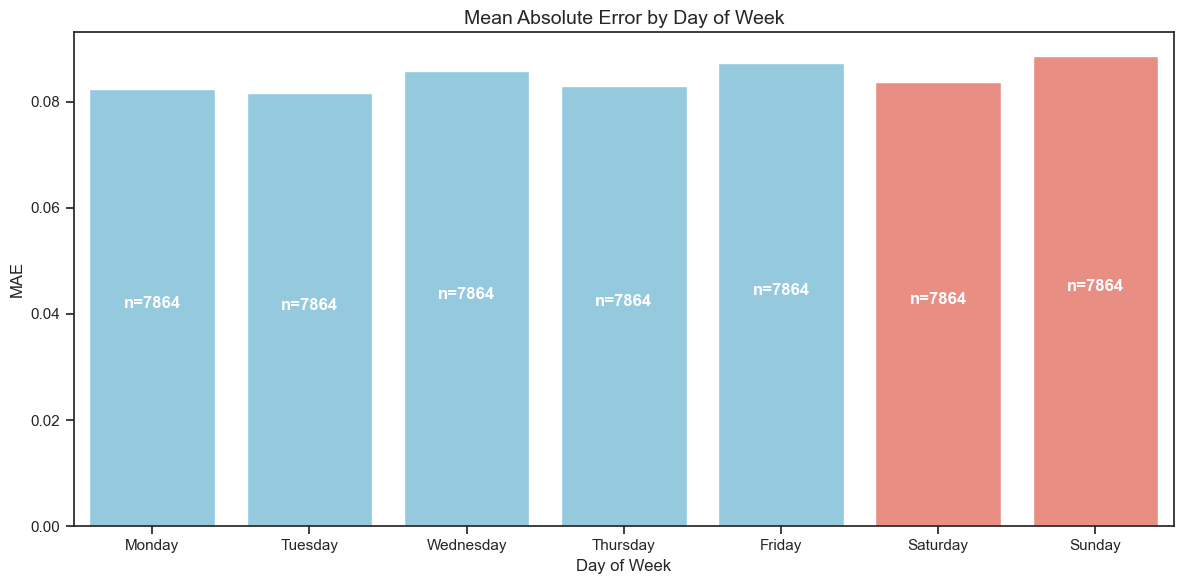

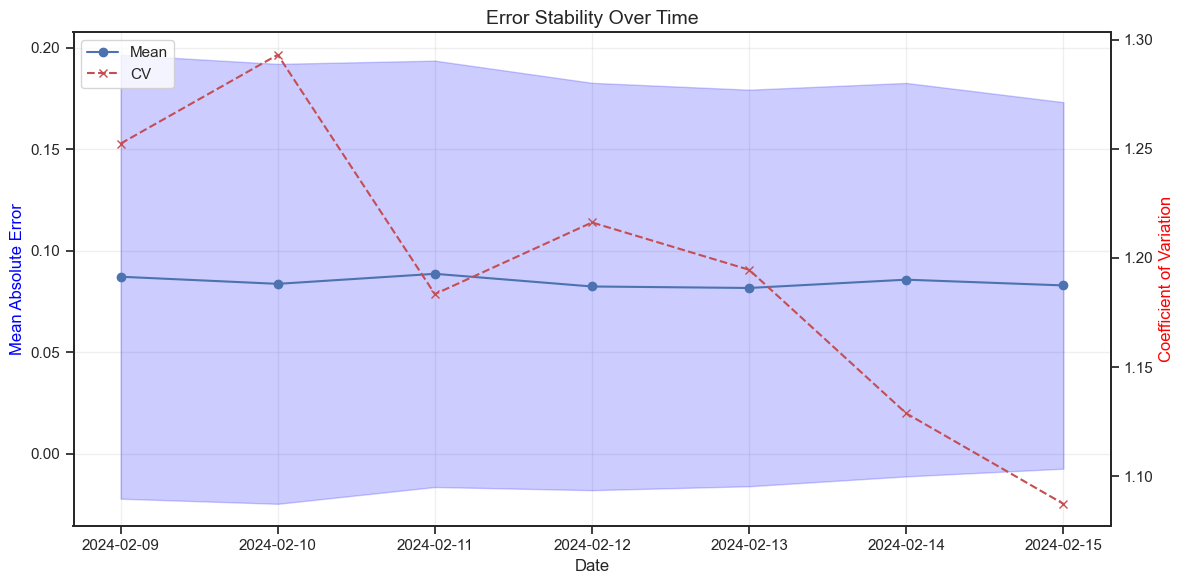


--- KEY TEMPORAL INSIGHTS ---
Weekend vs Weekday Difference: 2.59% higher error on weekends
Correlation between time and error: -0.0111
Best performing day: Tuesday (MAE = 0.0817)
Worst performing day: Sunday (MAE = 0.0886)
Average error volatility (CV): 1.1937


In [ ]:
if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Model_baseline\xgboost_results.csv"
    geojson_path = r"C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Temporal"
    daily_metrics_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Model\xgboost_results_daily_metrics.csv"

    # Run analysis
    run_simple_temporal_analysis(results_path, daily_metrics_path, output_dir)